# 【第44回_Beginner限定コンペ】診断データを使った糖尿病発症予測   

In [1]:
# ライブラリインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
# from sklearn.neural_network import 
import lightgbm as lgb

# 設定
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50

%matplotlib inline

In [2]:
# データの読み込み
dir_path = "/Users/Tomoki Yako/tech/competition/SIGNATE/diabetes/data/"

train_df = pd.read_csv(dir_path + "train.csv", encoding='utf-8')
test_df = pd.read_csv(dir_path + "test.csv", encoding='utf-8')

In [3]:
train_df.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,200,9,125,74,0,0,28.536910,0.444902,45,1
1,3832,4,109,80,0,0,28.047673,0.238243,22,0
2,4927,4,88,78,39,0,52.371341,0.279471,26,0
3,4088,9,125,74,0,0,40.062688,0.203922,45,0
4,3644,5,107,78,44,284,52.935068,0.284959,45,1


In [4]:
train_df.shape

(3000, 10)

In [5]:
test_df.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,398,0,126,80,0,0,40.096264,0.822517,21
1,3833,3,88,60,20,0,39.810590,0.204331,22
2,4836,3,114,76,0,0,33.198760,0.521011,21
3,4572,1,146,74,0,0,26.890259,0.504950,38
4,636,1,123,90,26,140,40.270088,0.800513,28


In [6]:
test_df.shape

(2000, 9)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 234.5 KB


In [8]:
test_df.isnull().sum()

index                       0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [9]:
df = pd.concat([train_df, test_df], ignore_index=True)
df.shape

(5000, 10)

In [10]:
# 基礎集計
df.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,3000.000000
mean,2499.500000,3.567800,113.957600,68.752800,11.180000,11.741600,35.347125,0.400987,28.989400,0.239000
std,1443.520003,3.040535,21.333505,16.268147,14.232446,47.022061,7.496245,0.271619,8.509722,0.426544
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,0.000775,0.137377,21.000000,0.000000
25%,1249.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.453978,0.232290,22.000000,0.000000
50%,2499.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.828671,0.269691,26.000000,0.000000
75%,3749.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.627290,0.506604,33.000000,0.000000
max,4999.000000,13.000000,199.000000,110.000000,52.000000,744.000000,53.400629,2.302072,67.000000,1.000000


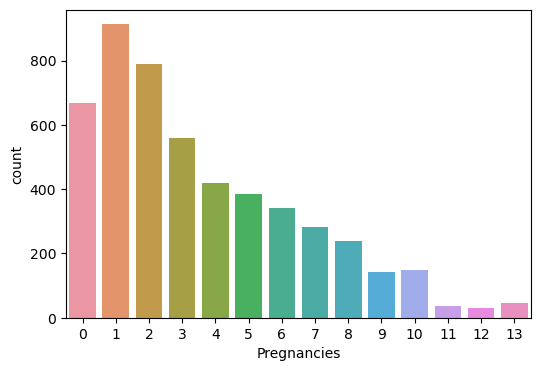

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Pregnancies")
plt.show()

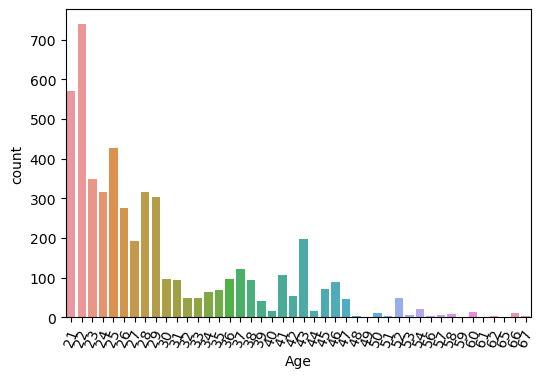

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Age')
plt.xticks(rotation=70)
plt.show()

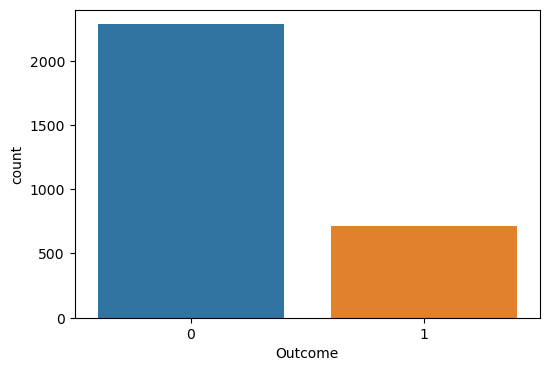

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='Outcome')
plt.show()

In [14]:
print("Glucoseの最大値", df['Glucose'].max())
print("Glucoseの最小値", df['Glucose'].min())

Glucoseの最大値 199
Glucoseの最小値 57


In [15]:
# データの分割
X_train = train_df.drop(columns=['index', 'Outcome'])
y_train = train_df['Outcome']
print("元のデータフレーム", train_df.shape)
print("説明変数", X_train.shape)
print("目的変数", y_train.shape)

元のデータフレーム (3000, 10)
説明変数 (3000, 8)
目的変数 (3000,)


In [16]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [17]:
y_tr.value_counts()

Outcome
0    1826
1     574
Name: count, dtype: int64

In [18]:
y_va.value_counts()

Outcome
0    457
1    143
Name: count, dtype: int64

In [19]:
X_test = test_df.drop(columns=['index'])
X_test.shape

(2000, 8)

In [20]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_tr, y_tr)

DecisionTreeClassifier(random_state=42)

In [21]:
y_tr_pred_dt = dt.predict(X_tr)
y_va_pred_dt = dt.predict(X_va)

accuracy_tr_dt = accuracy_score(y_tr, y_tr_pred_dt)
accuracy_va_dt = accuracy_score(y_va, y_va_pred_dt)

In [22]:
print("学習データの精度", accuracy_tr_dt)
print("評価データの精度", accuracy_va_dt)

学習データの精度 1.0
評価データの精度 0.735


In [23]:
lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_tr, y_tr)

LogisticRegression(max_iter=200, random_state=42)

In [24]:
y_tr_pred_lr = lr.predict(X_tr)
y_va_pred_lr = lr.predict(X_va)

accuracy_tr_lr = accuracy_score(y_tr, y_tr_pred_lr)
accuracy_va_lr = accuracy_score(y_va, y_va_pred_lr)

print("学習データの精度", accuracy_tr_lr)
print("評価データの精度", accuracy_va_lr)

学習データの精度 0.77375
評価データの精度 0.77


In [25]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr, y_tr)

y_tr_pred_rf = rf.predict(X_tr)
y_va_pred_rf = rf.predict(X_va)

accuracy_tr_rf = accuracy_score(y_tr, y_tr_pred_rf)
accuracy_va_rf = accuracy_score(y_va, y_va_pred_rf)
print("学習データの精度", accuracy_tr_rf)
print("評価データの精度", accuracy_va_rf)

# RandomForestClassifier　を使用して予測
# y_test_pred_rf = rf.predict(X_test)

# test_df['Outcome'] = y_test_pred_rf
# test_df['Outcome'] = test_df['Outcome'].astype(int)

# submit_df = test_df[['index', 'Outcome']].set_index('index')
# submit_df['Outcome'].value_counts()

# submit_df.to_csv("../data/submission_rf.csv", header=False)

学習データの精度 1.0
評価データの精度 0.81


In [26]:
svc = SVC(random_state=42)
svc.fit(X_tr, y_tr)

y_tr_pred_svc = svc.predict(X_tr)
y_va_pred_svc = svc.predict(X_va)

accuracy_tr_svc = accuracy_score(y_tr, y_tr_pred_svc)
accuracy_va_svc = accuracy_score(y_va, y_va_pred_svc)
print("学習データの精度", accuracy_tr_svc)
print("評価データの精度", accuracy_va_svc)


学習データの精度 0.7666666666666667
評価データの精度 0.7566666666666667


In [27]:
n_neighbors = 3
knc = KNeighborsClassifier(n_neighbors=n_neighbors)
knc.fit(X_tr, y_tr)

y_tr_pred_knc = knc.predict(X_tr)
y_va_pred_knc = knc.predict(X_va)

accuracy_tr_knc = accuracy_score(y_tr, y_tr_pred_knc)
accuracy_va_knc = accuracy_score(y_va, y_va_pred_knc)
print("学習データの精度", accuracy_tr_knc)
print("評価データの精度", accuracy_va_knc)

学習データの精度 0.8575
評価データの精度 0.7583333333333333


In [28]:
bnb = BernoulliNB()
bnb.fit(X_tr, y_tr)

y_tr_pred_bnb = bnb.predict(X_tr)
y_va_pred_bnb = bnb.predict(X_va)

accuracy_tr_bnb = accuracy_score(y_tr, y_tr_pred_bnb)
accuracy_va_bnb = accuracy_score(y_va, y_va_pred_bnb)

print("学習データの精度", accuracy_tr_bnb)
print("評価データの精度", accuracy_va_bnb)

学習データの精度 0.7608333333333334
評価データの精度 0.7616666666666667


In [29]:
lgb.LGBMClassifier()

LGBMClassifier()

In [30]:
train_data = lgb.Dataset(X_tr, label=y_tr)
eval_data = lgb.Dataset(X_va, label=y_va, reference=train_data)

In [31]:
params = {
            'task':         'train',
            'boosting_type':'gbdt',
            'objective':    'binary',
            'verbose':      '2',
            'force_col_wise':'True',
            'random_state': '42'
}

In [32]:
gbm = lgb.train(params,
                train_data,
                valid_sets=eval_data,
                )

[LightGBM] [Info] Number of positive: 574, number of negative: 1826
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239167 -> initscore=-1.157254
[LightGBM] [Info] Start training from score -1.157254
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] T

In [33]:
y_tr_prob_gbm = gbm.predict(X_tr)
y_tr_pred_gbm = np.where(y_tr_prob_gbm < 0.5, 0, 1)
y_va_prob_gbm = gbm.predict(X_va)
y_va_pred_gbm = np.where(y_va_prob_gbm < 0.5, 0, 1)

# y_va_pred_gbm[:5]
accuracy_tr_gbm = accuracy_score(y_tr, y_tr_pred_gbm)
accuracy_va_gbm = accuracy_score(y_va, y_va_pred_gbm)

print("学習データの精度", accuracy_tr_gbm)
print("評価データの精度", accuracy_va_gbm)

y_test_prob_gbm = gbm.predict(X_test)
y_test_pred_gbm = np.where(y_test_prob_gbm < 0.5, 0, 1)

test_df['Outcome'] = y_test_pred_gbm
test_df['Outcome'] = test_df['Outcome'].astype(int)

submit_df = test_df[['index', 'Outcome']].set_index('index')
submit_df['Outcome'].value_counts()

submit_df.to_csv("../data/submission_gbm.csv", header=False)

学習データの精度 0.96875
評価データの精度 0.81


In [ ]:
voting_clf = VotingClassifier(estimators=[('dt', dt), ('lr', lr), ('rf', rf), ('svc', svc), ('knc', knc), ('bnb', bnb)], voting='hard')
# VotingClassifierを使用して学習
voting_clf.fit(X_tr, y_tr)

y_tr_pred_vote = voting_clf.predict(X_tr)
y_va_pred_vote = voting_clf.predict(X_va)

accuracy_tr_vote = accuracy_score(y_tr, y_tr_pred_vote)
accuracy_va_vote = accuracy_score(y_va, y_va_pred_vote)

print("学習データの精度", accuracy_tr_vote)
print("評価データの精度", accuracy_va_vote)

# VotingClassifier　を使用して予測
y_test_pred_vote = voting_clf.predict(X_test)

test_df['Outcome'] = y_test_pred_vote
test_df['Outcome'] = test_df['Outcome'].astype(int)

submit_df = test_df[['index', 'Outcome']].set_index('index')
submit_df['Outcome'].value_counts()

submit_df.to_csv("../data/submission.csv", header=False)